<a href="https://colab.research.google.com/github/AngKS/practices/blob/master/GAN/Pokemon_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:
!nvidia-smi

Mon Feb 28 06:20:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# using tensorflow ImageDataGenerator to import Pokemon Images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale = (1. / 255.),
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    "/content/drive/MyDrive/pokemonGAN",
    target_size=(256, 256),
    batch_size=32


)


Found 819 images belonging to 1 classes.


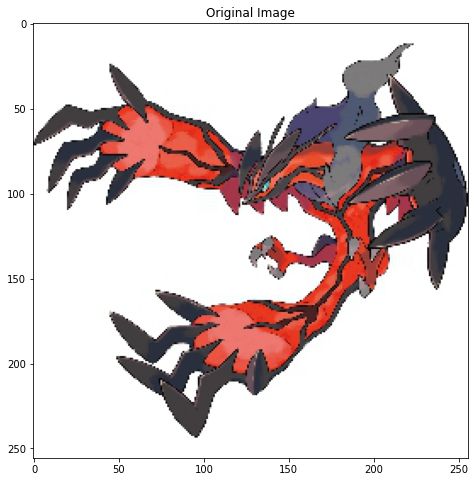

In [4]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

images = load_img(
    "/content/drive/MyDrive/pokemonGAN/pokemon_jpg/717.jpg",
    target_size=(256, 256)
)
img_tensor = img_to_array(images)
img_tensor = np.expand_dims(img_tensor, axis=0)

# plot images without Augmentation
plt.figure(figsize=(8, 8))
image = img_tensor[0].astype('float32')
image /= 255.
plt.imshow(image)
plt.title("Original Image")
plt.show()


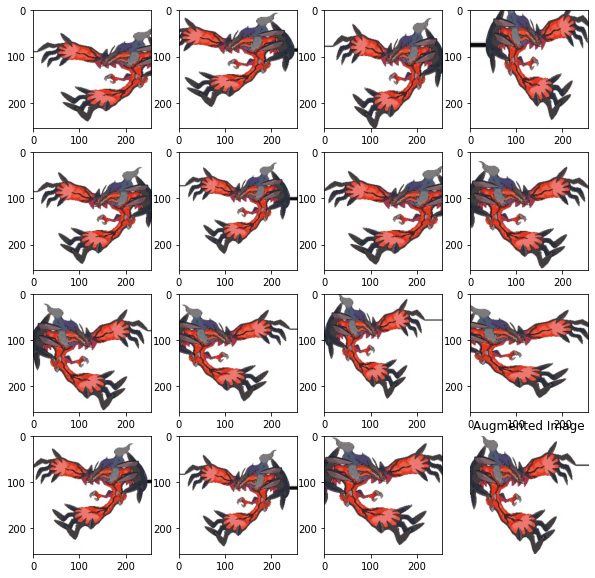

In [5]:
# After Augmentation

# create a batch of this one image
pic = datagen.flow(img_tensor, batch_size=1)

plt.figure(figsize=(10, 10))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image = batch[0].astype('float32')
    plt.imshow(image)
plt.suptitle("Augmented Image")
plt.axis('off')
plt.show()

In [6]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

In [7]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(
                'Please initialize `TimeDistributed` layer with a '
                '`Layer` instance. You passed: {input}'.format(input=layer))
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.v = self.add_weight(shape=(1, self.w_shape[0] * self.w_shape[1] * self.w_shape[2]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_v',
                                 dtype=tf.float32)

        self.u = self.add_weight(shape=(1, self.w_shape[-1]),
                                 initializer=tf.initializers.TruncatedNormal(stddev=0.02),
                                 trainable=False,
                                 name='sn_u',
                                 dtype=tf.float32)

        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self.update_weights()
        output = self.layer(inputs)
        self.restore_weights()  # Restore weights because of this formula "W = W - alpha * W_SN`"
        return output
    
    def update_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        
        u_hat = self.u
        v_hat = self.v  # init v vector

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)

                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.v.assign(v_hat)

        self.layer.kernel.assign(self.w / sigma)

    def restore_weights(self):
        self.layer.kernel.assign(self.w)

In [8]:
discriminator = Sequential(
    [
        Input((256, 256, 3)),
        SpectralNormalization(Conv2D(64, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        SpectralNormalization(Conv2D(128, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        SpectralNormalization(Conv2D(256, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        SpectralNormalization(Conv2D(256, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        SpectralNormalization(Conv2D(512, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        SpectralNormalization(Conv2D(128, (3, 3), strides=2, padding='same')),
        BatchNormalization(momentum=0.8),
        LeakyReLU(alpha=0.2),

        Dropout(0.2),
                            
        SpectralNormalization(Conv2D(128, (3, 3), strides=1, padding='same')),
        GlobalAveragePooling2D(),
        Dense(2048),
        Dense(256),
        Dense(1, activation='sigmoid')
    ],
    name="Discriminator"
)

In [9]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization (Spe  (None, 128, 128, 64)     1883      
 ctralNormalization)                                             
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 spectral_normalization_1 (S  (None, 64, 64, 128)      74560     
 pectralNormalization)                                           
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                     

In [10]:
latent_dim = 128

generator = Sequential([
                        Input(shape=(latent_dim, )),
                        Dense(2 * 2 * latent_dim),
                        Reshape((2, 2, latent_dim)),

                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),
                        
                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),
                        
                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),

                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),

                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),

                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),

                        UpSampling2D(),
                        Conv2D(128, (3, 3), padding='same'),
                        BatchNormalization(momentum=0.8),
                        Activation('relu'),

                        Conv2D(3, (4, 4), padding='same'),
                        Activation('tanh')
],
name='Generator')

In [11]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 reshape (Reshape)           (None, 2, 2, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 128)        512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 4, 4, 128)         0 

In [12]:
class DCGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()

        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracking = tf.keras.metrics.Mean(name='generator-loss')
        self.disc_loss_tracking = tf.keras.metrics.Mean(name='discriminator-loss')

    @property
    def metrics(self):
        return [self.gen_loss_tracking, self.disc_loss_tracking]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_img = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_img, real_images], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # sample random point sin the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        #Assemble misleading labels
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.gen_loss_tracking.update_state(g_loss)
        self.disc_loss_tracking.update_state(d_loss)

        return {
            'd_loss': self.disc_loss_tracking.result(),
            'g_loss': self.gen_loss_tracking.result(),
        }

In [13]:
import warnings
warnings.filterwarnings('ignore')

# Custom callback to display generated images every n epochs and after training
class GANMonitor(tf.keras.callbacks.Callback):

    def __init__(self, num_img=10, latent_dim=128, patience=1, vmin=0, vmax=1):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.random_latent_vectors = tf.random.normal(
            shape=(num_img, self.latent_dim))


    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict(self.random_latent_vectors)
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        # Generate Matplotlib Figure
        row_size = np.ceil(self.num_img/5)
        fig = plt.figure(figsize=(8, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.show()

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            # self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        # self.save_weights('Full Train')

In [14]:
batch_size = 32

gan = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

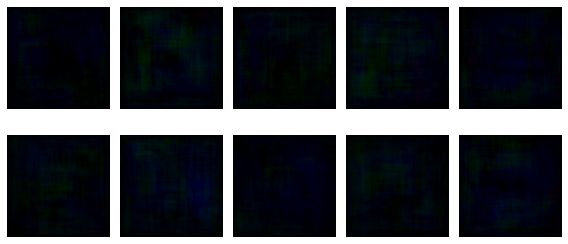

Epoch 1/70
 8/26 [========>.....................] - ETA: 24s - d_loss: 0.7022 - g_loss: 0.6544

In [ ]:
results = gan.fit(train_data, epochs=70, callbacks=[GANMonitor()])